In [1]:
import matplotlib.pyplot as plt
import numpy as np
import torch
import torch.nn as nn
import torch.nn.functional as F

In [2]:
%config InlineBackend.figure_format = 'svg'

In [3]:
def showHeapMaps(metrics,xlabel,ylabel,titles=None,figure_size=(2.5,2.5),cmap="Reds"):
    num_rows,num_cols = metrics.shape[0],metrics.shape[1]
    fig, axes = plt.subplots(num_rows, num_cols, figsize=figure_size,sharex=True, sharey=True, squeeze=False)
    for i,(row_axes,row_metrics) in enumerate(zip(axes,metrics)):
        for j,(ax,metric) in enumerate(zip(row_axes,row_metrics)):
            pcm = ax.imshow(metric.detach().numpy())
            if i == num_rows - 1:
                ax.set_xlabel(xlabel)
            if j == 0:
                ax.set_ylabel(ylabel)
            if titles:
                ax.set_title(titles[j])
    fig.colorbar(pcm, ax=axes, shrink=0.6);

In [4]:
def plot_kernel_reg(x_test,x_train,y_train,y_true,y_pre):
    plt.plot(x_test.detach().numpy(),y_true.detach().numpy(),label='Truth')
    plt.plot(x_test.detach().numpy(),y_pre.detach().numpy(),label='Pred')
    plt.scatter(x_train.detach().numpy(),y_train.detach().numpy(),label='Train',color='red')
    plt.legend()
    plt.show()

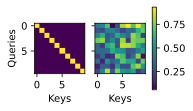

In [5]:
a = torch.eye(10).reshape((1, 1, 10, 10))
b = torch.sigmoid(torch.randn((10,10))).reshape((1,1,10,10))
attention_weights = torch.cat((a,b),dim=1)
showHeapMaps(attention_weights, xlabel='Keys', ylabel='Queries')

In [6]:
train_samples = 100
test_samples = 50
limits = 5

def f(x):
    return 2 * torch.sin(x) + x ** 0.8

x_train,_ = torch.sort(torch.rand(train_samples) * limits)    # return 排序后的张量，排序后的原始张量的索引
y_train = f(x_train) + torch.normal(0,0.5,(train_samples,))
x_test = torch.arange(0,limits,limits/test_samples)
y_true = f(x_test)
x_train


tensor([1.2738e-03, 7.5879e-02, 7.6519e-02, 8.3059e-02, 1.5569e-01, 1.6638e-01,
        1.8608e-01, 2.9899e-01, 3.1085e-01, 5.5834e-01, 5.9658e-01, 6.5337e-01,
        6.9473e-01, 7.9458e-01, 8.2162e-01, 8.7723e-01, 9.3107e-01, 9.4376e-01,
        9.5813e-01, 9.7338e-01, 1.0761e+00, 1.0804e+00, 1.1175e+00, 1.1279e+00,
        1.1322e+00, 1.1630e+00, 1.2360e+00, 1.2361e+00, 1.2429e+00, 1.4075e+00,
        1.4212e+00, 1.5315e+00, 1.5800e+00, 1.6473e+00, 1.6923e+00, 1.7383e+00,
        1.7841e+00, 1.8162e+00, 1.9099e+00, 2.0091e+00, 2.1649e+00, 2.2589e+00,
        2.3100e+00, 2.4017e+00, 2.4141e+00, 2.6255e+00, 2.6501e+00, 2.7933e+00,
        2.8949e+00, 2.9229e+00, 2.9439e+00, 3.0332e+00, 3.0526e+00, 3.1344e+00,
        3.2235e+00, 3.2369e+00, 3.3033e+00, 3.3924e+00, 3.5540e+00, 3.5727e+00,
        3.6392e+00, 3.7015e+00, 3.7784e+00, 3.8851e+00, 4.0667e+00, 4.1125e+00,
        4.1818e+00, 4.2355e+00, 4.2438e+00, 4.2910e+00, 4.2975e+00, 4.3231e+00,
        4.3474e+00, 4.3794e+00, 4.3944e+

# 不带参数的注意力汇聚

1. 不带参数，代表注意力汇聚无法学习训练

2. 实现给定好 键值对， 根据注意力汇聚算法，让查询和键放到一起计算，计算完的结果会有一个注意力的汇聚权重，用于选取关键值。

- 要求 键值对的数据质量良好，并且不能有太多的噪声

- 数据样本要足够多，一定程度上可以规避噪声的影响

- 模型编码器要学习好良好的全局信息

torch.Size([50]) torch.Size([50]) torch.Size([100]) torch.Size([100])


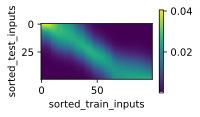

In [7]:
x_repeat = x_test.repeat_interleave(train_samples,dim=-1).reshape(-1,train_samples)    # (test_samples,train_samples)
attention_weights = F.softmax(-(x_repeat - x_train) ** 2 /2 ,dim=-1)     # K -> test_x    ( test_samples,train_samples )
y_pre = (attention_weights @ y_train)
showHeapMaps(attention_weights.unsqueeze(0).unsqueeze(0), xlabel='sorted_train_inputs', ylabel='sorted_test_inputs')
print(x_test.shape,y_pre.shape,y_train.shape,x_train.shape)

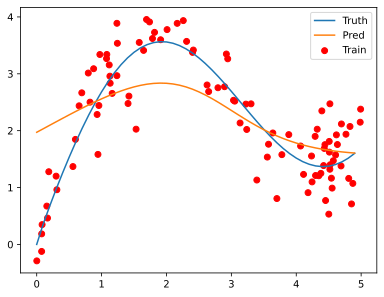

In [8]:
plot_kernel_reg(x_test,x_train,y_train,y_true,y_pre)

# 带参数的注意力汇聚

给注意力汇聚算法加上一个可学习的参数   ->  如果 注意力（K*Q） 不在指定的位置上，可以通过参数 w 来更改注意力资源   ->  给注意力权重添加惩罚系数

1. loss((K,Q,V),y_train)   -->  扔进去的训练标签带有噪声，但是通过注意力机制，预测曲线却趋近于没有噪声的曲线

2. 通过观察热力图，注意力权重结合了对角线周围的点。从而让整体拟合真实的函数曲线

3. 通过实验，给对角线添加掩码 和 不添加掩码效果差不多。
给K,V 对角线添加掩码主要原因是   x_train,y_train 输入进去的时候 模型会通过K,V 的对角线直接定位到正确答案（作弊）


In [9]:
a = torch.arange(10)

a

tensor([0, 1, 2, 3, 4, 5, 6, 7, 8, 9])

In [10]:
class NWKernelRegression(nn.Module):
    def __init__(self,device='cpu'):
        super().__init__()
        self.w = nn.Parameter(torch.rand((1,),requires_grad=True,device=device))
    def forward(self,K,Q,V):
        '''
        K  (batch_size,datas)
        Q  (batch_size)
        V  (batch_size,datas)
        '''
        Q = Q.unsqueeze(1).repeat(1,K.shape[1])
        self.attention_weights = torch.softmax( - ((Q-K)*self.w)**2 /2 ,-1 )  # ( batch_size,datas )
        return torch.bmm(  self.attention_weights.unsqueeze(1), V.unsqueeze(-1) ).reshape(-1) 

In [26]:
epoches = 5
lr = 0.05   # 调整学习率让模型收敛
device = 'cpu'

In [22]:
x_set = x_train.repeat(train_samples).reshape(-1,train_samples)
y_set = y_train.repeat(train_samples).reshape(-1,train_samples)
# 把对角线上的元素用掩码遮住，以防注意力作弊 or 过分依赖于噪声的数据  -> 数据集的答案就在 对角线上，这样注意力权重会极端过拟合
K = x_set[ ( 1-torch.eye(train_samples) ).type(torch.bool) ].reshape(-1,train_samples-1).to(device)
V = y_set[ ( 1-torch.eye(train_samples) ).type(torch.bool) ].reshape(-1,train_samples-1).to(device)

# K = x_set.to(device)
# V = y_set.to(device)


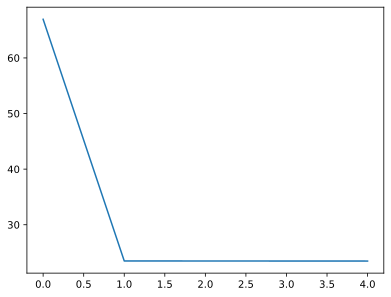

In [23]:
net = NWKernelRegression(device=device)
criterion = nn.MSELoss(reduction='none')
opt = torch.optim.SGD(net.parameters(),lr = lr)
losses = []
for epoch in range(epoches):
    x_train = x_train.to(device)
    y_train = y_train.to(device)
    opt.zero_grad()
    loss = criterion(net(K,x_train,V),y_train).sum()
    loss.backward()
    opt.step()
    losses.append(loss.item())

plt.plot(range(epoches),losses)
plt.show()

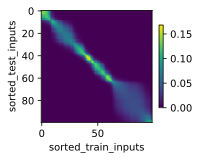

In [24]:
showHeapMaps(net.attention_weights.unsqueeze(0).unsqueeze(0).to('cpu'), xlabel='sorted_train_inputs', ylabel='sorted_test_inputs')

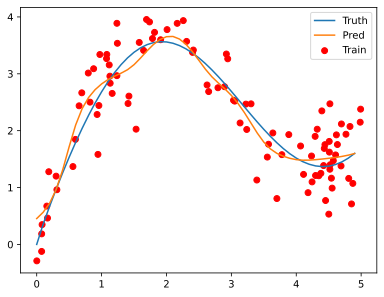

In [25]:
# keys的形状:(n_test，n_train)，每一行包含着相同的训练输入（例如，相同的键）
keys = x_train.repeat((test_samples, 1))
# value的形状:(n_test，n_train)
values = y_train.repeat((test_samples, 1))
y_hat = net(keys, x_test, values).unsqueeze(1).detach()
plot_kernel_reg(x_test,x_train,y_train,y_true,y_hat)